step1. import library

In [ ]:
import shutil
import glob
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, lfilter, iirnotch
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.utils import shuffle
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight, shuffle
import numpy as np


drive.mount('/content/drive') # Google Drive Mounting



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


step2. 경로 설정 및 inbody data 불러오기 및 정규화

In [ ]:
# file path
base_path = '/content/drive/MyDrive/Colab Notebooks/'
excel_path = base_path + 'inbody_data.xlsx'

print(f"File Path: {excel_path}")
print(f"Loading InBody Data from: {excel_path}")

inbody_df = pd.read_excel(excel_path, header=1)
numeric_feats = ['weight', 'SMM', 'BFM']
print(f"Selected InBody Features: {numeric_feats}")

scaler_inbody = StandardScaler()
inbody_scaled = scaler_inbody.fit_transform(inbody_df[numeric_feats])


inbody_final = pd.DataFrame(inbody_scaled, columns=numeric_feats)
inbody_final['participant'] = inbody_df['participant']
inbody_stats = inbody_final.set_index('participant')


inbody_dict = inbody_stats.T.to_dict('list')


file_map_df = inbody_df[['Unnamed: 9', 'Unnamed: 10']].dropna()
file_to_participant = dict(zip(file_map_df['Unnamed: 10'], file_map_df['Unnamed: 9']))

print("✅ InBody Processing Complete (3 Features Only).")


train_folder_path = base_path + 'sEMG_data/'
test_folder_path = base_path + 'sEMG_data_test/'

print(f"Train Folder: {train_folder_path}")
print(f"Test Folder : {test_folder_path}")


all_train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
all_test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')
all_train_files.sort()
all_test_files.sort()

print(f"Files Found: Train={len(all_train_files)}, Test={len(all_test_files)}")


File Path: /content/drive/MyDrive/Colab Notebooks/inbody_data.xlsx
Loading InBody Data from: /content/drive/MyDrive/Colab Notebooks/inbody_data.xlsx
Selected InBody Features: ['weight', 'SMM', 'BFM']
✅ InBody Processing Complete (3 Features Only).
Train Folder: /content/drive/MyDrive/Colab Notebooks/sEMG_data/
Test Folder : /content/drive/MyDrive/Colab Notebooks/sEMG_data_test/
Files Found: Train=25, Test=3


/tmp/ipython-input-4270447382.py:30: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  inbody_dict = inbody_stats.T.to_dict('list')


step3. sEMG 데이터 로드 및 필터링

In [ ]:
all_train_files = glob.glob(train_folder_path + 'sEMG_data_*.csv')
all_test_files = glob.glob(test_folder_path + 'sEMG_data_*.csv')
all_train_files.sort()
all_test_files.sort()

# filter functions
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    if high >= 1.0: high = 0.99
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_semg_filters(data_array, fs=200):
    b_band, a_band = butter_bandpass(20, 95, fs, order=4)
    filtered_data = lfilter(b_band, a_band, data_array)
    b_notch, a_notch = iirnotch(w0=60, Q=30, fs=fs)
    filtered_data = lfilter(b_notch, a_notch, filtered_data)
    return filtered_data

def get_flatline_mask(series, window_size=20):
    is_flat = series.rolling(window=window_size).std().fillna(0) == 0
    is_small = series <= 6
    return is_flat | is_small


def process_and_filter_files(file_list, purpose="Train"):
    processed_list = []
    target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']

    print(f"--- Processing {purpose} Files ({len(file_list)} files) ---")

    for idx, f_path in enumerate(file_list):
        try:

            filename_full = os.path.basename(f_path)
            filename_key = os.path.splitext(filename_full)[0]

            df = pd.read_csv(f_path)
            df_filtered = df.copy()

            for ch in target_channels:
                raw_signal = df[ch].values
                filtered_signal = apply_semg_filters(raw_signal, fs=200)
                bad_mask = get_flatline_mask(df[ch], window_size=40)
                filtered_signal[bad_mask] = 0.0
                df_filtered[ch] = filtered_signal


            processed_list.append((df_filtered, filename_key))   # (Dataframe, filekey) tuple 저장

            if idx == 0 or (idx + 1) % 10 == 0:
                print(f"[{idx+1}/{len(file_list)}] Done: {filename_key}")

        except Exception as e:
            print(f"Error processing {f_path}: {e}")

    return processed_list


train_dfs_with_name = process_and_filter_files(all_train_files, purpose="Train")
test_dfs_with_name = process_and_filter_files(all_test_files, purpose="Test")


--- Processing Train Files (25 files) ---
[1/25] Done: sEMG_data_0
[10/25] Done: sEMG_data_17
[20/25] Done: sEMG_data_4
--- Processing Test Files (3 files) ---
[1/3] Done: sEMG_data_25


step4. Normalization 시계열 데이터만(MVC, MinMax, Zscore)

In [ ]:
target_channels = ['Ch1', 'Ch2', 'Ch3', 'Ch4']
SCALER_TYPE = 'Zscore' # MVC

train_dfs_only = [item[0] for item in train_dfs_with_name]
all_train_values = np.concatenate([df[target_channels].values for df in train_dfs_only])

if SCALER_TYPE == 'Zscore':
    scaler = StandardScaler()
    scaler.fit(all_train_values)
    def apply_normalization(data_values, scaler_obj):
        return scaler_obj.transform(data_values)

elif SCALER_TYPE == 'MVC':
    mvc_values = np.max(np.abs(all_train_values), axis=0) + 1e-8
    scaler = mvc_values
    def apply_normalization(data_values, scaler_obj):
        return data_values / scaler_obj

print("✅ Scaler fitted on Train Data.")



✅ Scaler fitted on Train Data.


step5.Windowing(실험 + inbody 결합)

In [ ]:
WINDOW_SIZE = 80
OVERLAP = 40



def create_windows_merge_classes(processed_data_list, scaler_obj, inbody_dict, file_to_participant, window_size=40, overlap=20):
    X_time_list = []
    X_inbody_list = []
    y_list = []
    step = window_size - overlap

    for (df, filename_key) in processed_data_list:
        raw_vals = df[target_channels].values
        data_norm = apply_normalization(raw_vals, scaler_obj)
        labels = df['label'].values

        p_id = file_to_participant.get(filename_key)
        if p_id is None or p_id not in inbody_dict: continue
        inbody_feat = inbody_dict[p_id]

        if len(data_norm) < window_size: continue

        for i in range(0, len(data_norm) - window_size + 1, step):
            window_label = labels[i + window_size - 1]

            # label encoding
            if window_label == 1:
                new_label = 0  # Lv1 -> 0
            elif window_label == 2:
                new_label = 1  # Lv2 -> 1
            elif window_label == 3:
                new_label = 2  # Lv3 -> 2
            elif window_label == 4:
                new_label = 3  # Lv4-> 3
            else:
                continue


            X_time_list.append(data_norm[i : i + window_size])
            y_list.append(new_label)
            X_inbody_list.append(inbody_feat)

    return np.array(X_time_list), np.array(X_inbody_list), np.array(y_list)




print("Creating Datasets")
X_train_time, X_train_inbody, y_train = create_windows_merge_classes(train_dfs_with_name, scaler, inbody_dict, file_to_participant, window_size=WINDOW_SIZE, overlap=OVERLAP)
X_test_time, X_test_inbody, y_test = create_windows_merge_classes(test_dfs_with_name, scaler, inbody_dict, file_to_participant, window_size=WINDOW_SIZE, overlap=OVERLAP)

print(f"Train Labels: {np.unique(y_train)}")
print(f"✅ Train Data Shape: {X_train_time.shape}")
print(f"⏳ Creating Datasets (4 Classes, Window={WINDOW_SIZE})...")
print(f"✅ Train Labels: {np.unique(y_train)}")

Creating Datasets
Train Labels: [0 1 2 3]
✅ Train Data Shape: (7019, 80, 4)
⏳ Creating Datasets (4 Classes, Window=80)...
✅ Train Labels: [0 1 2 3]


step6. AI model formation (여러가지 모델 구조 비교 + Functional API + Concatenate)

Class Weights: {0: np.float64(0.8215121722846442), 1: np.float64(1.1022298994974875), 2: np.float64(1.1499017038007864), 3: np.float64(0.9941926345609066)}

 Testing: Model_A_Base
   - Dropout: 0.3
   - Filters: [64, 128]
   -> Result: Max Val Accuracy = 0.4580
  Current Best Model Updated

 Testing: Model_B_HighDrop
   - Dropout: 0.5
   - Filters: [64, 128]
   -> Result: Max Val Accuracy = 0.4516

 Testing: Model_C_Light
   - Dropout: 0.3
   - Filters: [32, 64]
   -> Result: Max Val Accuracy = 0.4516

 Testing: Model_D_Deep
   - Dropout: 0.4
   - Filters: [64, 128, 256]
   -> Result: Max Val Accuracy = 0.3219


🎉 Experiment Finished!
 Best Model: Model_A_Base
 Best Val Accuracy: 0.4580

[Final Evaluation on Test Set]
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2609 - loss: 1.6934
Final Test Accuracy: 27.97%

📊 Visualization for Best Model: Model_A_Base


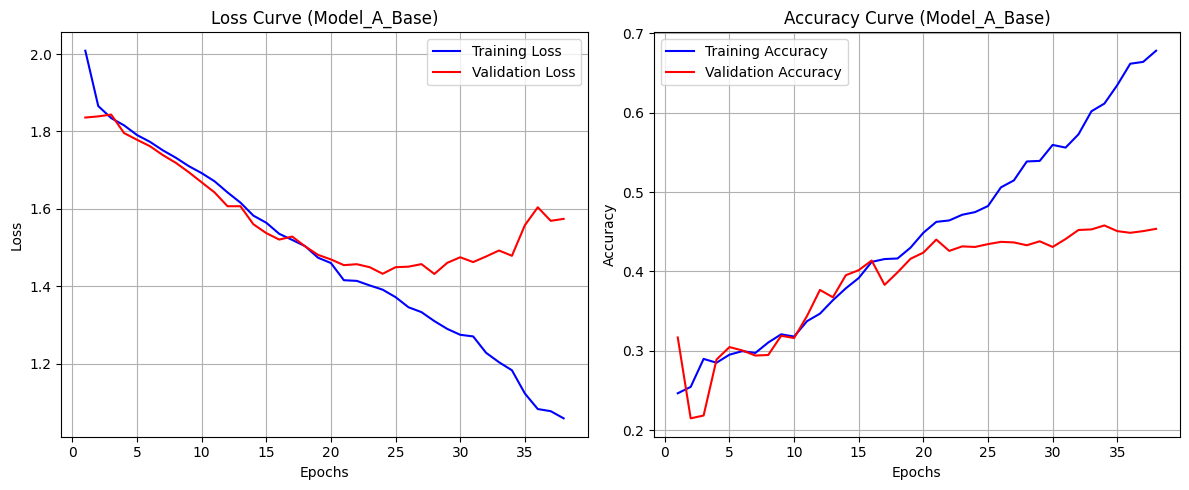

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


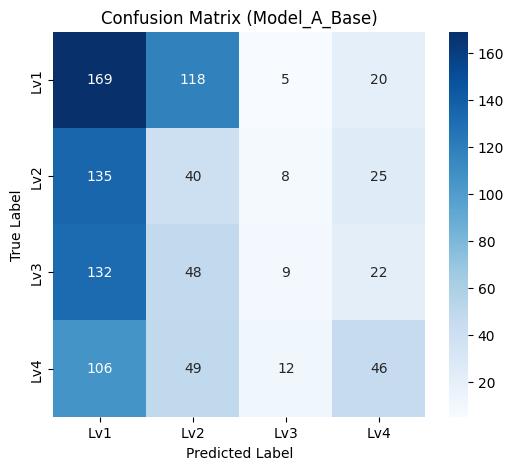


[Classification Report]
              precision    recall  f1-score   support

         Lv1       0.31      0.54      0.40       312
         Lv2       0.16      0.19      0.17       208
         Lv3       0.26      0.04      0.07       211
         Lv4       0.41      0.22      0.28       213

    accuracy                           0.28       944
   macro avg       0.29      0.25      0.23       944
weighted avg       0.29      0.28      0.25       944



In [ ]:
X_train_time, X_train_inbody, y_train = shuffle(X_train_time, X_train_inbody, y_train, random_state=42)

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")


def build_model(config):
    input_time = Input(shape=(80, 4), name='Time_Input')
    input_inbody = Input(shape=(3,), name='InBody_Input')

    # Config에서 설정 가져오기
    drop_rate = config['dropout']
    filters = config['filters']
    dense_units = config['dense']

    x = input_time

    # CNN Layers
    for f in filters:
        x = Conv1D(f, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling1D(2)(x)
        x = Dropout(drop_rate)(x)

    x = Flatten()(x)

    # Dense Layers
    for d in dense_units:
        x = Dense(d, activation='relu', kernel_regularizer=l2(0.001))(x)
        x = Dropout(drop_rate)(x)

    # InBody data Concatenate
    combined = Concatenate()([x, input_inbody])
    output = Dense(4, activation='softmax')(combined)

    model = Model(inputs=[input_time, input_inbody], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model



experiment_configs = [
    # Model A:  (Dropout 0.3)
    {'name': 'Model_A_Base', 'dropout': 0.3, 'filters': [64, 128], 'dense': [128, 64, 16]},

    # Model B:  (Dropout 0.5)
    {'name': 'Model_B_HighDrop', 'dropout': 0.5, 'filters': [64, 128], 'dense': [128, 64, 16]},

    # Model C: small filters
    {'name': 'Model_C_Light', 'dropout': 0.3, 'filters': [32, 64], 'dense': [64, 32]},

    # Model D: Deeper CNN
    {'name': 'Model_D_Deep', 'dropout': 0.3, 'filters': [64, 128, 256], 'dense': [128, 64]} #dropout 0.4
]




best_acc = 0.0
best_model = None
best_history = None
best_config_name = ""

for config in experiment_configs:
    print(f"\n============================================")
    print(f" Testing: {config['name']}")
    print(f"   - Dropout: {config['dropout']}")
    print(f"   - Filters: {config['filters']}")
    print(f"============================================")

    model = build_model(config)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

    history = model.fit(
        x=[X_train_time, X_train_inbody],
        y=y_train,
        epochs=80,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, reduce_lr],
        class_weight=class_weights_dict,
        verbose=0 #  (진행바 없음)
    )

    # 최고 Validation Accuracy 확인
    val_acc = max(history.history['val_accuracy'])
    print(f"   -> Result: Max Val Accuracy = {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = model
        best_history = history
        best_config_name = config['name']
        print("  Current Best Model Updated")


print(f"Experiment Finished!")
print(f" Best Model: {best_config_name}")
print(f" Best Val Accuracy: {best_acc:.4f}")

# Analyzing Test set using top model
print("\n[Final Evaluation on Test Set]")
loss, acc = best_model.evaluate([X_test_time, X_test_inbody], y_test)
print(f"Final Test Accuracy: {acc*100:.2f}%")

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

print(f"\n=======================================================")
print(f"📊 Visualization for Best Model: {best_config_name}")
print(f"=======================================================")




# 1. Loss & Accuracy Curve
if best_history:
    acc = best_history.history['accuracy']
    val_acc = best_history.history['val_accuracy']
    loss = best_history.history['loss']
    val_loss = best_history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title(f'Loss Curve ({best_config_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title(f'Accuracy Curve ({best_config_name})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 2. Confusion Matrix Heatmap
y_pred_probs = best_model.predict([X_test_time, X_test_inbody])
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Lv1', 'Lv2', 'Lv3', 'Lv4'],
            yticklabels=['Lv1', 'Lv2', 'Lv3', 'Lv4'])
plt.title(f'Confusion Matrix ({best_config_name})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. Classification Report
print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=['Lv1', 'Lv2', 'Lv3', 'Lv4']))


step7. 모델 간략 정리

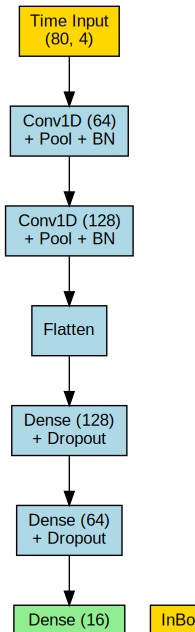

In [ ]:
import graphviz
from IPython.display import display

dot = graphviz.Digraph(comment='1D CNN Model Structure')

# [수정] size 속성 제거 (자동 크기 조절)
# dpi=100 정도로 설정하면 화면에 딱 적당하게 나옵니다.
dot.attr(rankdir='TB', dpi='100')

# 노드 스타일
dot.attr('node', shape='box', style='filled', fillcolor='lightblue', fontname='Helvetica', fontsize='12')

# 1. 입력
dot.node('Input_Time', 'Time Input\n(80, 4)', fillcolor='#FFD700')
dot.node('Input_InBody', 'InBody Input\n(3,)', fillcolor='#FFD700')

# 2. CNN
dot.node('CNN_1', 'Conv1D (64)\n+ Pool + BN')
dot.node('CNN_2', 'Conv1D (128)\n+ Pool + BN')
dot.node('Flatten', 'Flatten')

# 3. Dense
dot.node('Dense_128', 'Dense (128)\n+ Dropout')
dot.node('Dense_64', 'Dense (64)\n+ Dropout')
dot.node('Dense_16', 'Dense (16)\n(Bottleneck)', fillcolor='#90EE90')

# 4. 결합 및 출력
dot.node('Concat', 'Concatenate\n(16 + 3)', shape='ellipse', fillcolor='#FFA07A')
dot.node('Output', 'Final Output\n(4 Classes)', fillcolor='#FF6347')

# 연결
dot.edge('Input_Time', 'CNN_1')
dot.edge('CNN_1', 'CNN_2')
dot.edge('CNN_2', 'Flatten')
dot.edge('Flatten', 'Dense_128')
dot.edge('Dense_128', 'Dense_64')
dot.edge('Dense_64', 'Dense_16')

# 결합부 연결
dot.edge('Dense_16', 'Concat')
dot.edge('Input_InBody', 'Concat')
dot.edge('Concat', 'Output')

# 출력
display(dot)


